In [2]:
import numpy as np
#4차원 배열
x = np.random.rand(10,1,28,28) #무작위 데이터 생성
# 높이 28, 너비 28, 채널 1 데이터가 10개
x.shape

(10, 1, 28, 28)

In [3]:
x[0].shape #첫번째 데이터 접근

(1, 28, 28)

In [4]:
x[1].shape #두번째

(1, 28, 28)

In [5]:
x[0,0] # or x[0][0] 첫 채널의 공간데이터 접근

array([[0.51371083, 0.35800149, 0.24079921, 0.37872887, 0.40402875,
        0.68816978, 0.30016913, 0.76649811, 0.54009021, 0.92801779,
        0.61153888, 0.28179706, 0.59910368, 0.12963275, 0.9572865 ,
        0.43776238, 0.19869377, 0.83987469, 0.13520144, 0.35377187,
        0.61030115, 0.86553381, 0.78320731, 0.09460511, 0.83534998,
        0.51941251, 0.19473494, 0.290306  ],
       [0.73361715, 0.40490227, 0.3789102 , 0.18772639, 0.42159421,
        0.70135201, 0.50182932, 0.63398792, 0.20430146, 0.89318488,
        0.14732729, 0.89563844, 0.23689246, 0.07027921, 0.88004209,
        0.39874171, 0.1431217 , 0.44781777, 0.91189994, 0.44714037,
        0.87139784, 0.86219895, 0.52266258, 0.77971402, 0.84085699,
        0.97727418, 0.47737255, 0.34574269],
       [0.69349358, 0.31509509, 0.92326599, 0.29957771, 0.42312944,
        0.34637452, 0.0756164 , 0.35669253, 0.16396924, 0.93613396,
        0.50775669, 0.59786476, 0.18048923, 0.97879256, 0.58163263,
        0.96784288, 0.3955

In [7]:
def im2col(input_data, filter_h, filter_w, stride=1, pad=0):
    """다수의 이미지를 입력받아 2차원 배열로 변환한다(평탄화).
    
    Parameters
    ----------
    input_data : 4차원 배열 형태의 입력 데이터(이미지 수, 채널 수, 높이, 너비)
    filter_h : 필터의 높이
    filter_w : 필터의 너비
    stride : 스트라이드
    pad : 패딩
    
    Returns
    -------
    col : 2차원 배열
    """
    N, C, H, W = input_data.shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1

    img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))

    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]

    col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)
    return col

x1 = np.random.rand(1,3,7,7) #데이터 수, 채널 수 , 높이, 너비
col1 = im2col(x1, 5,5 ,stride=1, pad = 0)
print(col1.shape)

(9, 75)


In [8]:
x2 = np.random.rand(10,3,7,7) 
col2 = im2col(x2, 5, 5 ,stride=1, pad = 0)
print(col2.shape)

(90, 75)


In [9]:
class Convolution:
    def __init__(self, W, b, stride=1, pad=0):
        self.W = W #가중치
        self.b = b #편향
        self.stride = stride #스트라이드
        self.pad = pad #패딩
    
    def forward(self, x):
        FN, C, FH, FW = self.W.shape
        N, C, H, W = x.shape
        out_h = int(1 + (H + 2*self.pad - FH) / self.stride)
        out_w = int(1 + (W + 2*self.pad - FW) / self.stride)
        
        col = im2col(x, FH, FW, self.stride, self.pad)
        col_W = self.W.reshape(FN, -1).T #필터 전개
        out = np.dot(col, col_W) + self.b
        
        out = out.reshape(N, out_h, out_w, -1).transpose(0,3,1,2)
        
        return out

In [10]:
def col2im(col, input_shape, filter_h, filter_w, stride=1, pad=0):
    """(im2col과 반대) 2차원 배열을 입력받아 다수의 이미지 묶음으로 변환한다.
    
    Parameters
    ----------
    col : 2차원 배열(입력 데이터)
    input_shape : 원래 이미지 데이터의 형상（예：(10, 1, 28, 28)）
    filter_h : 필터의 높이
    filter_w : 필터의 너비
    stride : 스트라이드
    pad : 패딩
    
    Returns
    -------
    img : 변환된 이미지들
    """
    N, C, H, W = input_shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1
    col = col.reshape(N, out_h, out_w, C, filter_h, filter_w).transpose(0, 3, 4, 5, 1, 2)

    img = np.zeros((N, C, H + 2*pad + stride - 1, W + 2*pad + stride - 1))
    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            img[:, :, y:y_max:stride, x:x_max:stride] += col[:, :, y, x, :, :]

    return img[:, :, pad:H + pad, pad:W + pad]


In [11]:
class Pooling:
    def __init__(self, pool_h, pool_w, stride=1, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad
        
    def forward(self, x):
        N, C, H, W = x.shape
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_w) / self.stride)
        
        # 전개 1
        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        col = col.reshape(-1, self.pool_h * self.pool_w)
        
        #최댓값 2
        out = np.max(col, axis=1)
        
        #성형 3
        out = out.reshape(N, out_h, out_w, C).transpose(0,3,1,2)
        
        return out

In [22]:
class SimpleConvNet:
    def __init__(self, input_dim=(1, 28, 28), #입력데이터 (채널수, 높이, 너비)의 차원
                 conv_param = {'filter_num':30, 'filter_size':5,'pad':0, 'stride':1}, #합성곱 계층의 하이퍼 파라미터
                 hidden_size=100, output_size=10, weight_init_std=0.01):
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        input_size = input_dim[1]
        conv_output_size = (input_size - filter_size + 2*filter_pad ) / filter_stride + 1
        pool_output_size = int(filter_num * (conv_output_size/2) * (conv_output_size/2))
        #초기화 인수로 주어진 합성곱 계층의 하이퍼파라미터를 딕셔너리에서 꺼낸다
        #합성곱의 출력 크기를 계산
        
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num)
        self.params['W2'] = weight_init_std * np.random.randn(pool_output_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)
        
        #매개변수들을 params 딕셔너리에 저장한다.
        #1번층의 합성곱 계층의 가중치를 W1, 편향을 b1이라는 키로 저장
        #2번째 층의 완전연결 계층의 가중치와 편향을 W2와 b2 마지막 3번째 층의 완전연결 계층의 가중치와 편향을 W3과 b3라는 키로 각각 저장
        
        self.layers = OrderedDict()
        self.layers['Conv1'] = Convolution(self.params['W1'],self.params['b1'],conv_param['stride'],conv_param['pad'])
        self.layers['Relu1'] = Relu()
        self.layers['Pool1'] = Pooling(pool_h = 2, pool_w = 2, stride = 2)
        self.layers['Affine1'] = Affine(self.params['W2'],self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W3'],self.params['b3'])
        
        #OrderedDict인 Layers에 계층들을 차례로 추가한다.
        self.last_layer = SoftmaxWithLoss()
        #마지막인 소맥은 별도 변수에 저장한다.
        
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
            
        return x
        
    def loss(self, x, t):
        y = self.predict(x)
        return self.last_layer.forward(y, t)
    
    def gradient(self, x, t):
        #pro
        self.loss(x, t)
        
        #back
        dout = 1
        dout = self.last_layer.backward(dout)
        
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)
            
        #결과 저장
        grads = {}
        grads['W1'] = self.layers['Conv1'].dW
        grads['b1'] = self.layers['Conv1'].db
        grads['W2'] = self.layers['Affine1'].dW
        grads['b2'] = self.layers['Affine1'].db
        grads['W3'] = self.layers['Affine2'].dW
        grads['b3'] = self.layers['Affine2'].db
        
        return grads
        
        
        #accuracy까지 구현이 되어야 본문내용이 돌아가는 듯 한데
        #일단 아래꺼로 복붙해서 돌려보자

In [26]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import pickle
import numpy as np
from collections import OrderedDict
from common.layers import *
from common.gradient import numerical_gradient


class SimpleConvNet:
    """단순한 합성곱 신경망
    
    conv - relu - pool - affine - relu - affine - softmax
    
    Parameters
    ----------
    input_size : 입력 크기（MNIST의 경우엔 784）
    hidden_size_list : 각 은닉층의 뉴런 수를 담은 리스트（e.g. [100, 100, 100]）
    output_size : 출력 크기（MNIST의 경우엔 10）
    activation : 활성화 함수 - 'relu' 혹은 'sigmoid'
    weight_init_std : 가중치의 표준편차 지정（e.g. 0.01）
        'relu'나 'he'로 지정하면 'He 초깃값'으로 설정
        'sigmoid'나 'xavier'로 지정하면 'Xavier 초깃값'으로 설정
    """
    def __init__(self, input_dim=(1, 28, 28), 
                 conv_param={'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},
                 hidden_size=100, output_size=10, weight_init_std=0.01):
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        input_size = input_dim[1]
        conv_output_size = (input_size - filter_size + 2*filter_pad) / filter_stride + 1
        pool_output_size = int(filter_num * (conv_output_size/2) * (conv_output_size/2))

        # 가중치 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * \
                            np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num)
        self.params['W2'] = weight_init_std * \
                            np.random.randn(pool_output_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std * \
                            np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)

        # 계층 생성
        self.layers = OrderedDict()
        self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'],
                                           conv_param['stride'], conv_param['pad'])
        self.layers['Relu1'] = Relu()
        self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])

        self.last_layer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    def loss(self, x, t):
        """손실 함수를 구한다.

        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블
        """
        y = self.predict(x)
        return self.last_layer.forward(y, t)

    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        acc = 0.0
        
        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt) 
        
        return acc / x.shape[0]

    def numerical_gradient(self, x, t):
        """기울기를 구한다（수치미분）.

        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블

        Returns
        -------
        각 층의 기울기를 담은 사전(dictionary) 변수
            grads['W1']、grads['W2']、... 각 층의 가중치
            grads['b1']、grads['b2']、... 각 층의 편향
        """
        loss_w = lambda w: self.loss(x, t)

        grads = {}
        for idx in (1, 2, 3):
            grads['W' + str(idx)] = numerical_gradient(loss_w, self.params['W' + str(idx)])
            grads['b' + str(idx)] = numerical_gradient(loss_w, self.params['b' + str(idx)])

        return grads

    def gradient(self, x, t):
        """기울기를 구한다(오차역전파법).

        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블

        Returns
        -------
        각 층의 기울기를 담은 사전(dictionary) 변수
            grads['W1']、grads['W2']、... 각 층의 가중치
            grads['b1']、grads['b2']、... 각 층의 편향
        """
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
        grads['W2'], grads['b2'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W3'], grads['b3'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads
        
    def save_params(self, file_name="params.pkl"):
        params = {}
        for key, val in self.params.items():
            params[key] = val
        with open(file_name, 'wb') as f:
            pickle.dump(params, f)

    def load_params(self, file_name="params.pkl"):
        with open(file_name, 'rb') as f:
            params = pickle.load(f)
        for key, val in params.items():
            self.params[key] = val

        for i, key in enumerate(['Conv1', 'Affine1', 'Affine2']):
            self.layers[key].W = self.params['W' + str(i+1)]
            self.layers[key].b = self.params['b' + str(i+1)]


train loss:2.299805046952363
=== epoch:1, train acc:0.271, test acc:0.23 ===
train loss:2.2965192176010483
train loss:2.2920471236042714
train loss:2.2881062553988394
train loss:2.276986683356829
train loss:2.2597923010460557
train loss:2.2513260521498726
train loss:2.263858462742898
train loss:2.229904944338904
train loss:2.2123056850634963
train loss:2.1498356150213898
train loss:2.111830672138248
train loss:2.113224384066506
train loss:2.0126581341532326
train loss:1.9869703053611263
train loss:1.9859166319440034
train loss:1.8589936155022706
train loss:1.8039313698275072
train loss:1.745354971978733
train loss:1.6576452948765592
train loss:1.6394035942169267
train loss:1.499972753529964
train loss:1.36727654637779
train loss:1.4455343743096263
train loss:1.3040739482218147
train loss:1.3137178754327303
train loss:1.064488945679791
train loss:1.029563116679493
train loss:1.0034375419599981
train loss:0.9599427810167522
train loss:0.7586425042219078
train loss:0.8497498190746491
trai

train loss:0.2058270436019939
train loss:0.19825561749174972
train loss:0.29330156384682043
train loss:0.34773555583138516
train loss:0.10452243324600545
train loss:0.2741963212266048
train loss:0.3298969416948625
train loss:0.14598167043919896
train loss:0.21705583961707908
train loss:0.16433066046173714
train loss:0.23069786560725591
train loss:0.10295095566877838
train loss:0.2258056925749701
train loss:0.2520255762411054
train loss:0.12928212838548425
train loss:0.30530743171776686
train loss:0.2611395986379545
train loss:0.18672057702948944
train loss:0.18582097963419264
train loss:0.3770955210222475
train loss:0.1813839337955966
train loss:0.20930190139686328
train loss:0.2199316869563019
train loss:0.16736682110571457
train loss:0.22662250018637384
train loss:0.15521186332868392
train loss:0.2711712023563332
train loss:0.2410258514649286
train loss:0.11454090255007246
train loss:0.14140795134925702
train loss:0.18406841886492237
train loss:0.18456269469044634
train loss:0.314017

train loss:0.28492841692004006
train loss:0.2738082599639055
train loss:0.1151313728082935
train loss:0.18478357221620864
train loss:0.1387914836028244
train loss:0.17978990094188307
train loss:0.1813231460981294
train loss:0.17403033048195937
train loss:0.15610285223917533
train loss:0.12066607206775412
train loss:0.2019810386794095
train loss:0.09017610221589817
train loss:0.07679466766062623
train loss:0.10023686122574936
train loss:0.16685833363888058
train loss:0.11840277866959015
train loss:0.10503956593908745
train loss:0.28410868564487696
train loss:0.11216983066340573
train loss:0.13138035205703782
train loss:0.12103771199738977
train loss:0.19820893497321884
train loss:0.08180544747701181
train loss:0.24677496175844912
train loss:0.22355420752745858
train loss:0.15493049608343512
train loss:0.20404231506873985
train loss:0.15604543816725389
train loss:0.16806289240343614
train loss:0.19869295220592037
train loss:0.11998717201735218
train loss:0.18868166287697805
train loss:0.

train loss:0.061944393092430425
train loss:0.06869240433722001
train loss:0.11290213357688873
train loss:0.06385739302133113
train loss:0.16659627773754135
train loss:0.06474369641143257
train loss:0.06803033512412886
train loss:0.19307296564954865
train loss:0.08295326431216533
train loss:0.07579353385990406
train loss:0.1476800801085475
train loss:0.13636647461603263
train loss:0.14319730069067757
train loss:0.1922698644493697
train loss:0.22625439180287304
train loss:0.11677980691591594
train loss:0.09962017877945599
train loss:0.13459471615129356
train loss:0.12550274650955903
train loss:0.10169631746439865
train loss:0.1018621138851974
train loss:0.13309159056277556
train loss:0.0916919468659367
train loss:0.03812131602290263
train loss:0.1341561307405928
train loss:0.08482744875640619
train loss:0.22413828979620654
train loss:0.15326100088519728
train loss:0.05323673786620293
train loss:0.056362809024925076
train loss:0.03578235908514653
train loss:0.18993195711928565
train loss:

train loss:0.15034118643430738
train loss:0.05721376673036672
train loss:0.08928986804263703
train loss:0.116273992619488
train loss:0.05026265787739119
train loss:0.0917473941448762
train loss:0.039973314573577466
train loss:0.12487615197648338
train loss:0.13834529598684214
train loss:0.09951408448338464
train loss:0.13418880655966944
train loss:0.04927470007467201
train loss:0.0415353527508674
train loss:0.05401915167651669
train loss:0.10787767243719752
train loss:0.06739350479269145
train loss:0.12590152314442457
train loss:0.12847652369330273
train loss:0.034631262700795334
train loss:0.1156608885320604
train loss:0.07619891178731893
train loss:0.033131454640771996
train loss:0.03309687996513978
train loss:0.08510642468779314
train loss:0.12778450008261927
train loss:0.034577868224136596
train loss:0.0244893797573018
train loss:0.11172112486661122
train loss:0.03350194590791248
train loss:0.07231990869825732
train loss:0.1299583520635891
train loss:0.08211769040981626
train loss:

train loss:0.028414740323191853
train loss:0.053265085123740584
train loss:0.04812816081055708
train loss:0.12159130626914949
train loss:0.07180547803084145
train loss:0.09746103648133843
train loss:0.06618129512550833
train loss:0.020768866259450763
train loss:0.03746978835003287
train loss:0.05977472754500027
train loss:0.04124835324886274
train loss:0.04156066283522266
train loss:0.029006854498684596
train loss:0.036823282666592426
train loss:0.11750848913080542
train loss:0.028372639982896023
train loss:0.06820296073859942
train loss:0.027175767535977755
train loss:0.08708789565328416
train loss:0.09687630183684547
train loss:0.05650384976161124
train loss:0.03234304508621911
train loss:0.07679799920261388
train loss:0.08818642847464359
train loss:0.0232849497379143
train loss:0.10675585418337141
train loss:0.03074306597373068
train loss:0.0785403726083279
train loss:0.01912514857771923
train loss:0.021221864760322354
train loss:0.058626610329375176
train loss:0.09000684910591646
t

train loss:0.10145035565332595
train loss:0.01575533478595518
train loss:0.06005032848916726
train loss:0.02804233065454522
train loss:0.04902114652346817
train loss:0.045258164176010224
train loss:0.05035787332768621
train loss:0.020314613342292988
train loss:0.08940661515125385
train loss:0.0564384368668525
train loss:0.09023490998676205
train loss:0.05268623654684824
train loss:0.20641978080085366
train loss:0.08329345210102294
train loss:0.04054420570407797
train loss:0.019880176682441672
train loss:0.03535099759160695
train loss:0.1272541028944693
train loss:0.038992915655067524
train loss:0.02759787062462705
train loss:0.06925206955483436
train loss:0.07223083829521307
train loss:0.09470915093299298
train loss:0.08996860527672972
train loss:0.016350785605376776
train loss:0.019038182244022216
train loss:0.060361491498791636
train loss:0.07639872409227579
train loss:0.07139855557878695
train loss:0.07059507184898607
train loss:0.034711004739311234
train loss:0.0282416417523845
tra

train loss:0.11213313369156594
train loss:0.008690477988186871
train loss:0.03409659816686634
train loss:0.08895027046128497
train loss:0.028155036699995906
train loss:0.03993601567299466
train loss:0.02718335579816586
train loss:0.041347035282755254
train loss:0.04817721703629089
train loss:0.06861145538353225
train loss:0.1095768849857668
train loss:0.04520023312684874
train loss:0.027107916730028898
train loss:0.07962271316031667
train loss:0.07828296769471088
train loss:0.022876320382183297
train loss:0.028952772841415793
train loss:0.01375263759646642
train loss:0.010057610820315992
train loss:0.0633743024984108
train loss:0.012374953851359078
train loss:0.023834423578866178
train loss:0.03394502649556738
train loss:0.051495283377191656
train loss:0.05188487417649866
train loss:0.013359673861191513
train loss:0.055577855718491484
train loss:0.11191364076273005
train loss:0.06434212259048191
train loss:0.02648382901271318
train loss:0.0027137856795285582
train loss:0.04085062852164

train loss:0.049817362373258386
train loss:0.08519354216200721
train loss:0.05744054413113652
train loss:0.031320082393893396
train loss:0.009027844116857824
train loss:0.01638811360713607
train loss:0.016613653485917836
train loss:0.035155962449756634
train loss:0.02846354928183463
train loss:0.05543384008152314
train loss:0.028171866037491694
train loss:0.06765945504460959
train loss:0.019798252317475184
train loss:0.012647829060987744
train loss:0.02357460518232297
train loss:0.006228451640092008
train loss:0.029191771878537946
train loss:0.019563377623499842
train loss:0.12884336819441713
train loss:0.00931424375192293
train loss:0.009937179105056173
train loss:0.111376645779945
train loss:0.017375817581264455
train loss:0.015406861442897943
train loss:0.012727439910931917
train loss:0.030959465059481238
train loss:0.018550135038273092
train loss:0.023261449620230676
train loss:0.03161202343678906
train loss:0.051991294496945874
train loss:0.07424091270910868
train loss:0.025672365

train loss:0.026326194987089026
train loss:0.05137991370965154
train loss:0.03833711640219053
train loss:0.0887577333403578
train loss:0.0414956743739511
train loss:0.05201215980308019
train loss:0.0335420852062046
train loss:0.0743141182808108
train loss:0.024157353410008974
train loss:0.021959000274044304
train loss:0.029602546348593967
train loss:0.0324087261225328
train loss:0.06290395093235471
train loss:0.025979330806256876
train loss:0.027531471116432945
train loss:0.13157741769709866
train loss:0.034138920187770816
train loss:0.039606469501584446
train loss:0.030385584130353457
train loss:0.06714421856218786
train loss:0.08909730153816527
train loss:0.01786713081346748
train loss:0.023329275021611185
train loss:0.005322600830144885
train loss:0.026460898236950622
train loss:0.022151439247337677
=== epoch:5, train acc:0.983, test acc:0.982 ===
train loss:0.01760690923252656
train loss:0.05031647048877242
train loss:0.025605180061242044
train loss:0.023367609079630217
train loss:

train loss:0.009110702184462542
train loss:0.02057501424759105
train loss:0.04455575793950372
train loss:0.015393845955326647
train loss:0.005423438567377395
train loss:0.06986710273104184
train loss:0.023337268576650475
train loss:0.005162179958743895
train loss:0.011904860653572585
train loss:0.010269317761063235
train loss:0.0052435783143126215
train loss:0.02945756601376011
train loss:0.014447716322021435
train loss:0.021130928534569347
train loss:0.019332629943496354
train loss:0.025339824889021742
train loss:0.012166055208013993
train loss:0.013577630575568494
train loss:0.0055850705674912885
train loss:0.04731486264105086
train loss:0.018217115747854756
train loss:0.007141777685529198
train loss:0.00871412137520281
train loss:0.040621537392575756
train loss:0.03785108141400994
train loss:0.02375672827055638
train loss:0.010603877754047525
train loss:0.009835105290661903
train loss:0.06360091264283978
train loss:0.060368481344002856
train loss:0.0037941361241211015
train loss:0.0

train loss:0.03407510261144595
train loss:0.03567584195535858
train loss:0.010905988130928029
train loss:0.02633009374831883
train loss:0.008908059423588405
train loss:0.017819514413245485
train loss:0.028158243792834808
train loss:0.06352150516121013
train loss:0.010626961298103945
train loss:0.009992133318974977
train loss:0.021105605578339025
train loss:0.05205452217748223
train loss:0.033499890071628714
train loss:0.03306265198428561
train loss:0.09550275022110237
train loss:0.059154747842009275
train loss:0.021842054100520824
train loss:0.035165898073350424
train loss:0.005638018375497596
train loss:0.026853705612198624
train loss:0.046707251483661956
train loss:0.014674080081210596
train loss:0.02013515411701773
train loss:0.04705400325209934
train loss:0.02271538215093221
train loss:0.00986131978159172
train loss:0.029867416959528388
train loss:0.03358809034457088
train loss:0.00820571128608182
train loss:0.0037909579479542743
train loss:0.032190302041126294
train loss:0.0530533

train loss:0.02253886510883483
train loss:0.02412717212764589
train loss:0.020395715398338937
train loss:0.028527845071557853
train loss:0.00960616438622069
train loss:0.01358703494320256
train loss:0.016235021746179478
train loss:0.013724797963391622
train loss:0.017759994533443093
train loss:0.026175455671285982
train loss:0.01594855069236774
train loss:0.011130743483605045
train loss:0.024294331845717335
train loss:0.00673542670300607
train loss:0.00847943364391357
train loss:0.04639214117809288
train loss:0.00748835252684132
train loss:0.009287758694327597
train loss:0.020343507922446456
train loss:0.01450516550793468
train loss:0.026325227243216537
train loss:0.011399213447896725
train loss:0.016153976197824937
train loss:0.029411372023701223
train loss:0.02149336883538794
train loss:0.012004837266535498
train loss:0.030580500493987927
train loss:0.02389559192182429
train loss:0.005977985198154439
train loss:0.015659304512129386
train loss:0.017869413602750815
train loss:0.0187034

train loss:0.049568545040720516
train loss:0.03506940140956806
train loss:0.009092544911279553
train loss:0.013728593044387978
train loss:0.01797515002496655
train loss:0.027236551114688125
train loss:0.009083202427825397
train loss:0.004390400039364438
train loss:0.010970204135950101
train loss:0.017988221551306856
train loss:0.02455877488696532
train loss:0.045524451327732
train loss:0.014437185666253304
train loss:0.007912489086804123
train loss:0.011897081008969603
train loss:0.010332831761027535
train loss:0.033908656881497336
train loss:0.029090019766556764
train loss:0.013368192286804486
train loss:0.024368822103519875
train loss:0.013200651029677893
train loss:0.037964839378637906
train loss:0.020487673765068687
train loss:0.003348627100325684
train loss:0.012980781390493624
train loss:0.04012238502976919
train loss:0.021483961287487162
train loss:0.04077626636949164
train loss:0.007564458774673259
train loss:0.010364240181534987
train loss:0.012178109860543393
train loss:0.008

train loss:0.019735736930211915
train loss:0.02218800171593642
train loss:0.004432560992995642
train loss:0.002566921148360265
train loss:0.004691392683455469
train loss:0.053465865779918215
train loss:0.0562284715670087
train loss:0.011179167539396519
train loss:0.005446641037974773
train loss:0.006373476734961205
train loss:0.08446641292452632
train loss:0.004914695154237331
train loss:0.018474219062926785
train loss:0.007071645265228478
train loss:0.013272472745737184
train loss:0.03427966038215355
train loss:0.011236308532197852
train loss:0.01126575154920966
train loss:0.05957284227837807
train loss:0.014908324929839298
train loss:0.008887882602163203
train loss:0.005992036213510346
train loss:0.005823655847766506
train loss:0.00869260204441944
train loss:0.018179911310452327
train loss:0.017927189331071545
train loss:0.005697821942196036
train loss:0.009446984911468661
train loss:0.01613432923542139
train loss:0.01754674500665869
train loss:0.010177567873061826
train loss:0.01986

train loss:0.048309712607472646
train loss:0.007106780195307415
train loss:0.011650718584900622
train loss:0.010798421152776032
train loss:0.02546912137704815
train loss:0.010904606052975531
train loss:0.027051602832816397
train loss:0.04346996792016679
train loss:0.030895743174428635
train loss:0.030562641696395616
train loss:0.10308489955125115
train loss:0.008740171173631
train loss:0.04642536876106756
train loss:0.008571411864690959
train loss:0.0075523692797205555
train loss:0.0012993212859257288
train loss:0.055005272755130584
train loss:0.052041962932152463
train loss:0.032444172432546214
train loss:0.01700337247521641
train loss:0.014852192571912589
train loss:0.0392627703569453
train loss:0.10096051985257364
train loss:0.005705056092633798
train loss:0.07616695354994099
train loss:0.009644872116271533
train loss:0.010528658181131734
train loss:0.011789426397728625
train loss:0.013341392965401091
train loss:0.024333334794143128
train loss:0.01973504956107409
train loss:0.013837

train loss:0.01726703283191574
train loss:0.0035542530809643132
train loss:0.008351752188157346
train loss:0.011273862258650744
train loss:0.019969154805912798
train loss:0.00310684890242056
train loss:0.0037692514384617486
train loss:0.013515767841018664
train loss:0.0036139815589004
train loss:0.005360092425325705
train loss:0.007734191818508162
train loss:0.005444789116489061
train loss:0.07302687120753416
train loss:0.018087526416814402
train loss:0.016041603061813042
=== epoch:8, train acc:0.991, test acc:0.99 ===
train loss:0.003990055288610207
train loss:0.0034086789028193103
train loss:0.03583953298334357
train loss:0.006019508502533174
train loss:0.004234419272958084
train loss:0.011229668807099661
train loss:0.0024718795928073654
train loss:0.006707363981984512
train loss:0.0015670131287837028
train loss:0.006902000368736053
train loss:0.00518643791007969
train loss:0.0033777566236450375
train loss:0.007817026688804825
train loss:0.06377823983331059
train loss:0.0066697482402

train loss:0.03123137335162295
train loss:0.03941171863930054
train loss:0.0345229791442184
train loss:0.04044240920406221
train loss:0.01375387900778141
train loss:0.017430154117174815
train loss:0.016645244446419002
train loss:0.00732422062821466
train loss:0.007965506007799075
train loss:0.00801653838459794
train loss:0.007651615207384399
train loss:0.09399238955745932
train loss:0.04799330782012289
train loss:0.025934694245163384
train loss:0.017598312890840465
train loss:0.02521389913368293
train loss:0.016875153871477196
train loss:0.05734692912735518
train loss:0.007057185600331987
train loss:0.0056652815983425095
train loss:0.016709949630677064
train loss:0.011569893339141206
train loss:0.0951595245562702
train loss:0.006591666167164242
train loss:0.005126012929422968
train loss:0.006114380729687336
train loss:0.025903318472612496
train loss:0.013461507654244073
train loss:0.0012930371727183903
train loss:0.007366273548679085
train loss:0.022338532818628888
train loss:0.0035085

train loss:0.003984637801147072
train loss:0.015505448850543195
train loss:0.006352907185190695
train loss:0.0071175396194417965
train loss:0.0019101004292955926
train loss:0.015639045936864007
train loss:0.035740161668207746
train loss:0.010727613077976213
train loss:0.006764674639599805
train loss:0.012243623000552175
train loss:0.028364711375234698
train loss:0.022984629884786396
train loss:0.010884641268056479
train loss:0.0024561902789800695
train loss:0.0030310598459432525
train loss:0.029285895448937074
train loss:0.026096611630090204
train loss:0.04370309711022431
train loss:0.014408394199706506
train loss:0.001387782537960921
train loss:0.003034137287891832
train loss:0.013420648216485555
train loss:0.007714036099772451
train loss:0.005226587182702556
train loss:0.0011209624951300865
train loss:0.01888840157211351
train loss:0.06271343642429769
train loss:0.005372204695818794
train loss:0.005859382249891358
train loss:0.001555077316848679
train loss:0.01604574952825433
train l

train loss:0.00860086053417312
train loss:0.002631673946988043
train loss:0.031000485332909413
train loss:0.019082671825946383
train loss:0.006139479166576723
train loss:0.01518484944214839
train loss:0.002522671048045588
train loss:0.004386010493039337
train loss:0.004849386430615899
train loss:0.011280125883038127
train loss:0.0059705476727820875
train loss:0.030159828141677118
train loss:0.0017224333200976211
train loss:0.0016021067332773053
train loss:0.05327035601360918
train loss:0.0011079324605592492
train loss:0.004342472325389815
train loss:0.010976288186404918
train loss:0.005786177338306805
train loss:0.010954407606308192
train loss:0.006796459008359271
train loss:0.028623365593397426
train loss:0.1099917229259891
train loss:0.0012948196892916023
train loss:0.0019228010020650454
train loss:0.014708641843851187
train loss:0.006426975662357785
train loss:0.009932993488459307
train loss:0.022981552506048022
train loss:0.024142719474689146
train loss:0.0023106815960119336
train 

train loss:0.004588494256227758
train loss:0.002420961327800203
train loss:0.004484172739664173
train loss:0.02027420827505891
train loss:0.04066808515270358
train loss:0.0018145252725651814
train loss:0.005305568964123112
train loss:0.015415692752553245
train loss:0.0038070872730384697
train loss:0.005741609128348774
train loss:0.009992422968132826
train loss:0.029147159893081295
train loss:0.0031398724267572647
train loss:0.004665946045758847
train loss:0.04366662740641343
train loss:0.008343132281255794
train loss:0.010169771882361728
train loss:0.06198041060244397
train loss:0.006874568535931751
train loss:0.00607018691403772
train loss:0.0015770435748493222
train loss:0.01052795509768848
train loss:0.0071837280671963035
train loss:0.008604395138878961
train loss:0.0028865143302707957
train loss:0.007574999600469412
train loss:0.023017192628058188
train loss:0.02715249747648444
train loss:0.0071509659461298026
train loss:0.01253505377058044
train loss:0.00280357733469971
train loss

train loss:0.0016471660880270343
train loss:0.0029387985857788103
train loss:0.000999635057291087
train loss:0.007894566525072746
train loss:0.0036108377532355386
train loss:0.004362907990619968
train loss:0.007012142942370239
train loss:0.04746319429973655
train loss:0.049676825258640846
train loss:0.006131368779988488
train loss:0.00680511039920641
train loss:0.007547468060241346
train loss:0.004111352660135075
train loss:0.0020927882820791347
train loss:0.0047143171213941465
train loss:0.007962993261492697
train loss:0.01640342850710911
train loss:0.0020055316343543152
train loss:0.003927361382413518
train loss:0.0017321346387881523
train loss:0.007494247342170229
train loss:0.0060924119806970685
train loss:0.004373238861626078
train loss:0.005890428559322733
train loss:0.001265105498665109
train loss:0.005258506562608584
train loss:0.14183817191810572
train loss:0.0029090436206499
train loss:0.0014829290455231686
train loss:0.0048325614793468625
train loss:0.0071281024445147955
tra

train loss:0.0031431430312562386
train loss:0.024985743052066987
train loss:0.002213295049230323
train loss:0.00345149891710365
train loss:0.014524166507220134
train loss:0.002718946834679966
train loss:0.002050121597389877
train loss:0.039095542921756356
train loss:0.030724397080059633
train loss:0.01179396050541498
train loss:0.0009199624080506269
train loss:0.0040186943605186485
train loss:0.005854967254755072
train loss:0.003606022706031834
train loss:0.0061922323183730065
train loss:0.013681248621550466
train loss:0.002336918953086079
train loss:0.00619312695975189
train loss:0.017871554665020405
train loss:0.009273794082171242
train loss:0.007697836033034279
train loss:0.007410087195892578
train loss:0.021237081580556573
train loss:0.014414262063563806
train loss:0.006156904840732374
train loss:0.005495040771200951
train loss:0.019581934691866743
train loss:0.004963503027961145
train loss:0.01232248193804468
train loss:0.014511613876445317
train loss:0.0978837641547757
train loss

train loss:0.001630915089056366
train loss:0.012724342032056336
train loss:0.003805838742512167
train loss:0.01350072988763337
train loss:0.007138752166105022
train loss:0.004059895910494155
train loss:0.0035501104269559814
train loss:0.0020515071352850515
train loss:0.0013317369739159707
train loss:0.006561658446610115
train loss:0.04598684974839525
train loss:0.0018660029798862054
train loss:0.0062531463133508654
train loss:0.002036496911067891
train loss:0.0017934552647027014
train loss:0.04320009401829896
train loss:0.008626690296919082
train loss:0.002236527621860414
train loss:0.002833513437066949
train loss:0.03405953398992545
train loss:0.007074898165471208
train loss:0.012600642174517642
train loss:0.014157571199926618
train loss:0.010745549442182256
=== epoch:11, train acc:0.992, test acc:0.984 ===
train loss:0.004307622439892008
train loss:0.015747516191130195
train loss:0.0448196763916179
train loss:0.013230862706693335
train loss:0.0026460048365213474
train loss:0.01010441

train loss:0.0005279071744287673
train loss:0.006278680770549685
train loss:0.004225079307326195
train loss:0.024681185034513296
train loss:0.001806353320660376
train loss:0.01852525286406236
train loss:0.012840498792101656
train loss:0.0017525364450157214
train loss:0.0058310979890610955
train loss:0.014189091469603681
train loss:0.0003889265237842415
train loss:0.005181021627883364
train loss:0.008433824430593694
train loss:0.0012170622286088151
train loss:0.002983905350776787
train loss:0.01514382814651262
train loss:0.004754546642001383
train loss:0.003967206775485916
train loss:0.0032016788967773346
train loss:0.009857751694336107
train loss:0.00622287525907311
train loss:0.0017117822952034498
train loss:0.004013367403313819
train loss:0.000379153937762964
train loss:0.004324480360021198
train loss:0.00307124089079076
train loss:0.016193457167583046
train loss:0.016239861536417495
train loss:0.0027067144195496396
train loss:0.0013646386141871005
train loss:0.0017533555369759538
tr

train loss:0.0010217140639731145
train loss:0.0007242053695117889
train loss:0.001957971859729439
train loss:0.00840838057979146
train loss:0.002157918264070005
train loss:0.004986294152600737
train loss:0.004599346723502085
train loss:0.0013190974601274682
train loss:0.006792198932905105
train loss:0.04599439549942413
train loss:0.005645165174244795
train loss:0.0009290911095179177
train loss:0.0031433544976965755
train loss:0.007518110380078264
train loss:0.0014600852637208237
train loss:0.05247001192955647
train loss:0.001737848002831774
train loss:0.0020495432947024816
train loss:0.0018380883081915433
train loss:0.001596713173800413
train loss:0.003621755827872554
train loss:0.010232627260918616
train loss:0.006534782373880072
train loss:0.008079034674181293
train loss:0.00429992713299907
train loss:0.00820162789464434
train loss:0.010253949089964999
train loss:0.12460933978368406
train loss:0.004692283721802514
train loss:0.03972873870777931
train loss:0.011707652704609193
train l

train loss:0.0010856561374916827
train loss:0.0009880620309674667
train loss:0.003740889345446669
train loss:0.00479851554733515
train loss:0.001563408987911935
train loss:0.002092914879666774
train loss:0.002817533701643027
train loss:0.003612134349438289
train loss:0.0002380604624401601
train loss:0.006419230618829335
train loss:0.0007740057595061328
train loss:0.0010889559534666478
train loss:0.0012463233699816622
train loss:0.0020239974338196074
train loss:0.01406217795377705
train loss:0.0008374695395258992
train loss:0.0020614926849899353
train loss:0.002783139473600871
train loss:0.004564341222025192
train loss:0.0024755304338326786
train loss:0.0009640349703658915
train loss:0.0009295262402500483
train loss:0.005298993622913203
train loss:0.0012106801533031564
train loss:0.0034075019759881287
train loss:0.015242822208711933
train loss:0.0016782513296782597
train loss:0.005913679104300581
train loss:0.0008418863465993255
train loss:0.0005566700981759753
train loss:0.000734480507

train loss:0.002001439512434665
train loss:0.003404852736105135
train loss:0.0032306279761344704
train loss:0.020223636310635604
train loss:0.0014875310763801247
train loss:0.0014731021922909384
train loss:0.014408531202031827
train loss:0.0022404577784856726
train loss:0.001913316756905963
train loss:0.0060685811415877085
train loss:0.0004193038626278977
train loss:0.0008575683479277036
train loss:0.0035579873375579827
train loss:0.004372333188198523
train loss:0.003168058236901974
train loss:0.01233702784438638
train loss:0.02560181523437093
train loss:0.005548995330031991
train loss:0.011585689658593759
train loss:0.0011536793702108564
train loss:0.002893363586098676
train loss:0.023791668901688993
train loss:0.001956981926973817
train loss:0.06427736651656268
train loss:0.014127247089675532
train loss:0.03609622300917088
train loss:0.005051734375881023
train loss:0.052356053961604754
train loss:0.0073772064579669385
train loss:0.016657573067707793
train loss:0.001141067545592059
tr

train loss:0.0004488613857973844
train loss:0.002051594818025156
train loss:0.003867607594463085
train loss:0.0028730991908961488
train loss:0.003364022530328249
train loss:0.005818287931055693
train loss:0.0012460110664967588
train loss:0.004081330181290991
train loss:0.003691984677018561
train loss:0.0047423879073656226
train loss:0.0009467391938714542
train loss:0.007595574349137335
train loss:0.0040296459018048045
train loss:0.004075670109574781
train loss:0.011079070935966957
train loss:0.0036519211295973734
train loss:0.029200607085207584
train loss:0.0013527400125392885
train loss:0.011138711785063033
train loss:0.006277785019342064
train loss:0.0010619319475027084
train loss:0.005440513254230437
train loss:0.00665964621814215
train loss:0.006985954038523043
train loss:0.000684221094537928
train loss:0.001426158115544567
train loss:0.010446198017466353
train loss:0.0014889266246574774
train loss:0.012433274519919072
train loss:0.007477343270999468
train loss:0.029255598665825458

train loss:0.0008882035942411738
train loss:0.001792712383642349
train loss:0.0009920910287768714
train loss:0.0006701814815193506
train loss:0.0047724773752522145
train loss:0.0015575480431393232
train loss:0.014730975169777555
train loss:0.0013581245267369486
train loss:0.01095572618699078
train loss:0.006134437295957824
train loss:0.0007360495066833335
train loss:0.0006768246621490433
train loss:0.0002921675241518721
train loss:0.005989454580567766
train loss:0.004244252022714662
train loss:0.005773388823541749
train loss:0.0008620944596799947
train loss:0.0036287920150126275
train loss:0.0013719442509390115
train loss:0.0008099428598400558
train loss:0.000254097498857572
train loss:0.0034710723448763215
train loss:0.0002725140167315228
train loss:0.0015447096942707624
train loss:0.0014468391267923055
train loss:0.0034819342211283894
train loss:0.0025944342820695535
train loss:0.014412602162405667
train loss:0.013294096970834
train loss:8.016899788255875e-05
train loss:0.01309498193

train loss:0.007435280223367889
train loss:0.0026293163057502867
train loss:0.0012104735463043578
train loss:0.0020044139019653492
train loss:0.0010505037601288873
train loss:0.004320988080510177
train loss:0.004029587267802865
train loss:0.001235716791745618
train loss:0.01103907054296485
train loss:0.0014215255593414348
train loss:0.0008879005830943311
train loss:0.002584851091165424
train loss:0.00025496808629994603
train loss:0.0010951209171580244
train loss:0.0007965319560327438
train loss:0.005587426554259581
train loss:0.04882297575190471
train loss:0.0032995654362205774
train loss:0.0061903976242143055
train loss:0.0056592344635452655
train loss:0.0009506847187924035
train loss:0.00649867315370212
train loss:0.0007451680658580858
train loss:0.00012247742274346208
train loss:0.0030253904983236707
train loss:0.07785151047712048
train loss:0.0030635865885382755
train loss:0.005995463607468613
train loss:0.0009255783290950396
train loss:0.0011703044721657566
train loss:0.0069386654

train loss:0.0027031061721808055
train loss:0.0015030498666833184
train loss:0.0019666771375350185
train loss:0.0009217072189112098
train loss:0.004973472513471584
train loss:0.0011334430880690011
train loss:0.0006721410469723179
train loss:0.0010318273247518367
train loss:0.005091162174551101
train loss:0.0068584170045105555
train loss:0.0321216396169849
train loss:0.0038661546368268023
train loss:0.0034798204513077093
train loss:0.008072312145292583
train loss:0.0012130204404027492
train loss:0.0009917700127288981
train loss:0.0002839505133551401
train loss:0.049503111834706466
train loss:0.0025632008700706525
train loss:0.0002515515504031407
train loss:0.0013212767592354535
train loss:0.0005702752424946205
train loss:0.001032066958597419
train loss:0.003568031696614847
train loss:0.02290703520345208
train loss:0.0038542201162649454
train loss:0.006031874566564454
train loss:0.005322465612730352
train loss:0.0007538709553115425
train loss:0.11342951476209048
train loss:0.000674417981

train loss:0.002817069315517276
train loss:0.003990775047655854
train loss:0.04537640617025465
train loss:0.0016053806846125778
train loss:0.00574951860613122
train loss:0.0015601008939980904
train loss:0.0006900151208792233
train loss:0.0007003310856438926
train loss:0.002065073865885152
train loss:0.001875362703029214
train loss:0.001102066981336055
train loss:0.0008469987662536666
train loss:0.017865483211365617
train loss:0.00035014300473508794
train loss:0.0005781517479727576
train loss:0.002897330688670878
train loss:0.001196706948638484
train loss:0.0010879252610664538
train loss:0.004431480983182375
train loss:0.001298923238312714
train loss:0.0015327834955144717
train loss:0.002363779824093803
train loss:0.0015449446944872552
train loss:0.0008403159899264089
train loss:0.006067518868696725
train loss:0.0037310243677273476
train loss:0.002711001762391956
train loss:0.0008346348376104713
train loss:0.003316582387924622
train loss:0.0008514649090227774
train loss:0.00504460437153

train loss:0.00045960791227952276
train loss:0.0037813751311193728
train loss:0.004512640944256185
train loss:0.0012536758534195788
train loss:0.002298067129450413
train loss:0.0002469012177561125
train loss:0.0037310765562549404
train loss:0.0003158270912071539
train loss:0.0015837110819605748
train loss:0.0017204325624292716
train loss:0.0006154950162433745
train loss:0.002801737472534263
train loss:0.0010320895567540696
train loss:0.00035550075226351685
train loss:0.007993686661484258
train loss:0.0016807834085714338
train loss:0.000899709986118701
train loss:0.0013072904962576734
train loss:0.0016505490995518946
train loss:0.0006823687902169479
train loss:0.00213365853191102
train loss:0.0014911538410029707
train loss:0.004851068948323041
train loss:0.0008724591475075086
train loss:0.0011230221482019286
train loss:0.0015078001582466503
train loss:0.001719709128394163
train loss:0.003449065204106276
train loss:0.022850631204681216
train loss:0.000843327943849157
train loss:0.0005989

train loss:0.0004059853241746721
train loss:0.0034088255775089242
train loss:0.0005893431870322203
train loss:0.001310301424250869
train loss:0.0005661244962080599
train loss:0.004748590410312866
train loss:0.0028126601136880098
train loss:0.0010961324534805557
train loss:0.0003411766700944996
train loss:0.004201247382609097
train loss:0.0032563562164438244
train loss:0.010218006982154233
train loss:0.0002598773151794472
train loss:0.0006850106484678649
train loss:0.003904374352532041
train loss:0.0029972144093695125
train loss:0.0028171308907986403
train loss:0.0008433939720770971
train loss:0.026764480799965285
train loss:0.004206838048857049
train loss:0.000929773618778157
train loss:0.0028926475783062596
train loss:0.005605501410228347
train loss:0.00032819784920604757
train loss:0.00026205255800441354
train loss:0.0020217192671157114
train loss:0.0198391207877768
train loss:0.0013133563609389026
train loss:0.00038089517638336334
train loss:0.0027044864697868595
train loss:0.000129

train loss:0.002282824464389102
train loss:0.0013118626408832046
train loss:0.0017903294454186419
train loss:0.0005308028884346884
train loss:0.0008826125407975526
train loss:0.0028854862639540514
train loss:0.0001392272264114629
train loss:0.006093884757771709
train loss:0.0012130083731564261
train loss:0.0025413877826073157
train loss:0.0006743053593107431
train loss:0.0005537730001517694
train loss:0.001312433429904431
train loss:0.001143949707250465
train loss:0.003287115341061165
train loss:0.00023128816208097664
train loss:0.001723291191844237
train loss:0.0007136564183156842
train loss:0.0002283610054965692
train loss:0.002527735619466932
train loss:0.022749975305112007
train loss:0.0011358288222079493
train loss:0.011638435085169785
train loss:0.00885513747428845
train loss:0.00445054645767341
train loss:0.00014170062444198567
train loss:1.5900350022512504e-05
train loss:0.0028552883078203557
train loss:0.0041658560319655785
train loss:0.0013168812955484544
train loss:9.1208553

train loss:0.000554811259245536
train loss:0.001590515939106914
train loss:0.002397020928463659
train loss:0.009409977791815774
train loss:0.001323293397059469
train loss:0.004161394878055813
train loss:0.0009284076054390417
train loss:0.0015336548556171131
train loss:0.013730923616392374
train loss:0.0064149545956559365
train loss:0.0013115964298954055
train loss:0.00231086851647889
train loss:0.0015078155385264106
train loss:0.0034990345466394583
train loss:0.0012818329254373389
train loss:0.0001572141262307106
train loss:0.00012003030362628982
train loss:0.0007861098006332126
train loss:0.0013132948039750044
train loss:0.01846799951543472
train loss:0.0019274391577023308
train loss:0.0026333295680689844
train loss:0.000616386430778296
train loss:0.0015992848409562526
train loss:0.0004974330026537526
train loss:0.002718103615079971
train loss:0.0004933830717797207
train loss:0.0016038864215461818
train loss:0.0026085790236300543
train loss:0.00237289438723361
train loss:0.00494920721

train loss:0.0014765599056946277
train loss:0.0002034819172209385
train loss:0.0030355853528155163
train loss:0.0020475915946877644
train loss:0.004935116583021803
train loss:0.0017076593159694375
train loss:0.00031790666083289195
train loss:0.0006198385218369768
train loss:0.007011293277452663
train loss:0.0024197551344104363
train loss:0.0011087319323043834
train loss:0.00021811122649278042
train loss:0.0012553507232472504
train loss:0.0006301664366232896
train loss:0.00014872069136251587
train loss:0.0015645592940543912
train loss:0.002714804390702226
train loss:0.0007263051040878039
train loss:0.0011648070865806451
train loss:0.007497028597684958
train loss:0.0009665716981950244
train loss:6.731341646112548e-05
train loss:0.00015681265431278333
train loss:0.003262562160495871
train loss:6.81367954553166e-05
train loss:0.0003700825223137233
train loss:0.0029000780976804904
train loss:0.00017714770172734407
train loss:0.0010787518617555246
train loss:0.0002883538394782483
train loss:

train loss:0.0015747798354797087
train loss:0.0024683608969437647
train loss:0.005969971102384207
train loss:0.0030038860356826017
train loss:0.007727005614061908
train loss:0.0015406606078362895
train loss:0.0008135574290656823
train loss:0.0025741354539712985
train loss:0.007480339776778445
train loss:0.0023458811294005
train loss:0.0015168574065539946
train loss:0.043733111228524156
train loss:0.0007966277669221637
train loss:0.0002719439326260711
train loss:0.0009868399609951853
train loss:0.002608807167932662
train loss:3.44379490605316e-05
train loss:0.0040072208792114265
train loss:0.00018829153384990904
train loss:0.0012364629018249843
train loss:0.004609574026692665
train loss:0.0006954063160238377
train loss:0.0013700599368747493
train loss:0.010602332695348809
train loss:0.0025227507485013788
train loss:0.0168088348273403
train loss:0.002840986138963047
train loss:0.002235644057987615
train loss:0.04694254531722507
train loss:0.0005383507961507524
train loss:0.00600002511837

train loss:0.0010988206210798416
train loss:0.002138620060472931
train loss:0.0018317869313153215
train loss:0.00038649184029649995
train loss:0.00565767023458217
train loss:0.00039224479123915946
train loss:0.0005237735346175782
train loss:0.0030504000931199466
train loss:0.010189843462873912
train loss:0.0035107449851078994
train loss:0.001268138099152104
train loss:0.0036005025848298944
train loss:0.006777408892330079
train loss:0.0006335606752618589
train loss:0.00028132914010289205
train loss:0.00021561114066645986
train loss:0.0006894202706600892
train loss:6.361349149871939e-06
train loss:0.0010353301134985546
train loss:0.002760338817183909
train loss:0.003997171274957845
train loss:0.0002133554011791739
train loss:0.0007502450591057788
train loss:0.00012142658205736806
train loss:0.0018823544102784678
train loss:0.0011837452388755382
train loss:0.010991681402487945
train loss:0.0001025748861834654
train loss:0.0026650414552048503
train loss:0.0005299345030300957
train loss:0.0

train loss:0.00047868171836781684
train loss:0.001859933709742271
train loss:0.0036545177714277194
train loss:0.0021726563856041296
train loss:0.0006240544597920683
train loss:0.0005461148036882729
train loss:0.002452892827500128
train loss:0.01550616274086989
train loss:5.92794904137724e-05
train loss:0.0005474592557331645
train loss:0.0009461054220679028
train loss:9.493042903294422e-05
train loss:0.005193899914151915
train loss:0.0005073263768953806
train loss:0.024049576956612747
train loss:0.015957761926631495
train loss:0.00459810362696554
train loss:0.0006407925873284158
train loss:0.0030430399109226307
train loss:0.0003769051461324786
train loss:0.0006205711640711208
train loss:0.004696233959565518
train loss:0.0001582896406284048
train loss:0.0029232630550860357
train loss:0.0005195918718398843
train loss:0.0011061140250643508
train loss:0.002878729816023911
train loss:5.9196347260344565e-05
train loss:0.0009240588274008516
train loss:0.005300129187006263
train loss:0.00237017

train loss:0.00048611910873186794
train loss:0.0003942080538451395
train loss:0.0002649667647878878
train loss:0.00011846301768835476
train loss:0.0014346315219322056
train loss:0.0019094007011245832
train loss:0.0006036573307157213
train loss:0.0020479591843404984
train loss:0.0038181048954375805
train loss:0.0014020830977327535
train loss:0.0012395140480140896
train loss:0.0030113462324343056
train loss:0.005853526401654614
train loss:0.0005635361078932698
train loss:0.013739350354505969
train loss:0.0019353782724515875
train loss:0.0015554942732877747
train loss:0.0003183458641762146
train loss:0.0021306451345019153
train loss:0.0033984143219918566
train loss:0.00013742089965012948
train loss:0.0022300477312753937
train loss:0.002821125650540391
train loss:0.000550744065516132
train loss:0.0031996868814358316
train loss:0.0033035387064274885
train loss:0.0012744876571255132
train loss:0.0008122597449852127
train loss:0.030304068032542725
train loss:0.0005845721820031432
train loss:0

train loss:0.0025765776984602723
train loss:0.0010261897728404132
train loss:0.00025663047605998526
train loss:0.0015611456071367234
train loss:0.000234039361775463
train loss:0.0007343923963475678
train loss:0.001957952608443154
train loss:0.0012067652881543232
train loss:1.4807036778982494e-05
train loss:0.0019643770798021777
train loss:0.0021040720634169082
train loss:0.00017989282583097532
train loss:0.028409976931267285
train loss:0.0010258340047068402
train loss:0.0024253652431181954
train loss:0.004317348835917032
train loss:0.0012162618021455184
train loss:2.4614158584294007e-05
train loss:0.00032650785702079685
train loss:0.00012286283847403093
train loss:0.00013004960997584482
train loss:0.00015318177155211718
train loss:0.00027803600565098766
train loss:0.00036222184990905635
train loss:0.0005483763055203867
train loss:0.0032014050200543727
train loss:0.0002971218685455645
train loss:0.000127897127471653
train loss:0.0027084798744264195
train loss:0.0011881404205748472
train

train loss:0.0018804742689260958
train loss:0.00020211774584849888
train loss:0.00011929117512214909
train loss:0.0009793250963828928
train loss:0.0015699901926085416
train loss:0.0004831974956814644
train loss:0.00025266780757335556
train loss:0.00018136903687420252
train loss:0.0020170992156708007
train loss:0.003945234949965569
train loss:0.0014091489054537376
train loss:0.00035689530923891955
train loss:0.0003083122943436751
train loss:0.0006951239547617323
train loss:0.002118983445682396
train loss:0.0022997537778680303
train loss:0.00047991098281592945
train loss:0.0003034723299946239
train loss:0.003538500817124953
train loss:0.0002397260581865399
train loss:0.004401533387797745
train loss:0.00025569635093094145
train loss:0.0009667058498875288
train loss:0.00017286541425344428
train loss:0.0052467374919140134
train loss:0.0019159976143621907
train loss:0.0013693548550730184
train loss:5.060269188636422e-05
train loss:0.00199355795849696
train loss:0.0005368257730388906
train lo

train loss:0.0009317001863832329
train loss:0.0016919260476507818
train loss:0.0019178996694449654
train loss:0.00017844322722618147
train loss:0.0013206771044505074
train loss:0.000351415247230051
train loss:0.0045900209580971825
train loss:0.001555628347633832
train loss:0.0006693949910567278
train loss:0.0014033127559871428
train loss:0.0007208079648723516
train loss:0.0006057041213324531
train loss:6.766335572368423e-05
train loss:0.000588916087994106
train loss:0.0007852281390420794
train loss:0.001302017089474552
train loss:0.0013917176490442851
train loss:0.0020691004236749813
train loss:0.00011952995855160463
train loss:0.0003205489406048721
train loss:0.0002965853930100276
train loss:0.00031632654051220034
train loss:0.00020101262673527292
train loss:0.0003277605543898553
train loss:0.0425560965605934
train loss:0.0016901120864716986
train loss:0.002430177298399798
train loss:0.0012436054246479607
train loss:0.0016884679888767118
train loss:0.00023132901599091517
train loss:0.

train loss:0.0006964326001566008
train loss:0.0006068234105870866
train loss:0.003314374314985462
train loss:0.004148968325240998
train loss:0.0006752667801274846
train loss:6.0371065493428025e-05
train loss:0.007729152000055469
train loss:0.0004252800540334018
train loss:0.00034462950393836315
train loss:0.00031144727052882836
train loss:0.003699643608392605
train loss:0.0025662736058288216
train loss:0.0008772245765032251
train loss:0.0003351766398124412
train loss:0.006284908607601824
train loss:0.0013219013603421909
train loss:0.003982785283954873
train loss:0.00038313047435151117
train loss:0.003160804709834093
train loss:9.896420752470538e-05
train loss:0.0004039947557126213
train loss:0.0009878061837720869
train loss:8.13482502078668e-05
train loss:0.0001987567957057284
train loss:2.6463735504227934e-05
train loss:3.864447285971996e-05
train loss:0.0017961626409564017
train loss:0.0012061038920272201
train loss:0.0013157587073082708
train loss:0.005210401669837208
train loss:0.0

train loss:0.00034109017131480284
train loss:0.00016488719174445946
train loss:0.0005525738486792152
train loss:2.8904794264464145e-05
train loss:0.00021716029428963619
train loss:0.0022589406205603844
train loss:0.0029915512242093987
train loss:0.00021370072250651947
train loss:0.0042476008226559
train loss:0.0011923963274210745
train loss:0.00030484885771280104
train loss:4.8160603484968927e-05
train loss:0.003140944613402074
train loss:0.0063452618392761595
train loss:0.0003578651176703988
train loss:0.0006604890579072472
train loss:0.00011380719292996854
train loss:0.00026389058129198695
train loss:0.0006059569925100536
train loss:0.0008170012702192078
train loss:0.0012769297909126362
train loss:0.0007608645126942254
train loss:0.0057200450066147435
train loss:0.013652781961731822
train loss:0.0018121359186855297
train loss:6.0287726425905764e-05
train loss:0.0001557823021486637
train loss:0.0012504114011576424
train loss:0.002333705979652276
train loss:0.001882794036274321
train l

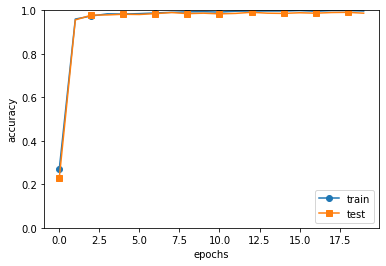

In [27]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from collections import OrderedDict
from common.trainer import Trainer
from common.layers import *
# 데이터 읽기
(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)

# 시간이 오래 걸릴 경우 데이터를 줄인다.
#x_train, t_train = x_train[:5000], t_train[:5000]
#x_test, t_test = x_test[:1000], t_test[:1000]

max_epochs = 20

network = SimpleConvNet(input_dim=(1,28,28), 
                        conv_param = {'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
                         hidden_size=100, output_size=10, weight_init_std=0.01)
                        
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=100,
                  optimizer='Adam', optimizer_param={'lr': 0.001},
                  evaluate_sample_num_per_epoch=1000)
trainer.train()

# 매개변수 보존
network.save_params("params.pkl")
print("Saved Network Parameters!")

# 그래프 그리기
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, trainer.train_acc_list, marker='o', label='train', markevery=2)
plt.plot(x, trainer.test_acc_list, marker='s', label='test', markevery=2)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()


# 다신 여기서 이거 돌리지말자!!! 

# 2시간 걸렸다!!

In [ ]:
from simple_convnet import SimpleConvNet

def filter_show(filters, nx=8, margin=3, scale=10):
    """
    c.f. https://gist.github.com/aidiary/07d530d5e08011832b12#file-draw_weight-py
    """
    FN, C, FH, FW = filters.shape
    ny = int(np.ceil(FN / nx))

    fig = plt.figure()
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

    for i in range(FN):
        ax = fig.add_subplot(ny, nx, i+1, xticks=[], yticks=[])
        ax.imshow(filters[i, 0], cmap=plt.cm.gray_r, interpolation='nearest')
    plt.show()


network = SimpleConvNet()
# 무작위(랜덤) 초기화 후의 가중치
filter_show(network.params['W1'])

# 학습된 가중치
network.load_params("params.pkl")
filter_show(network.params['W1'])
